<a href="https://colab.research.google.com/github/sarjakpatel/CMPE_297_Advanced_Deep_Learning/blob/main/Assignment%204/CMPE_297_Assignment_4_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMPE 297 Assignment 4 Part 2: Meta learning using prototypical networks in pytorch


## Importing Libraries

In [1]:
!pip install --quiet "torch>=1.6, <1.9" "matplotlib" "torchmetrics>=0.3" "seaborn" "torchvision" "pytorch-lightning>=1.3"

     |████████████████████████████████| 804.1 MB 2.6 kB/s 
     |████████████████████████████████| 529 kB 73.4 MB/s 
     |████████████████████████████████| 708 kB 44.9 MB/s 
     |████████████████████████████████| 707 kB 57.0 MB/s 
     |████████████████████████████████| 706 kB 60.9 MB/s 
     |████████████████████████████████| 706 kB 72.7 MB/s 
     |████████████████████████████████| 705 kB 69.6 MB/s 
     |████████████████████████████████| 705 kB 62.1 MB/s 
     |████████████████████████████████| 701 kB 66.6 MB/s 
     |████████████████████████████████| 700 kB 66.7 MB/s 
     |████████████████████████████████| 585 kB 66.8 MB/s 
     |████████████████████████████████| 19.1 MB 964 kB/s 
     |████████████████████████████████| 19.1 MB 501 kB/s 
     |████████████████████████████████| 21.0 MB 1.3 MB/s 
     |████████████████████████████████| 23.2 MB 1.6 MB/s 
     |████████████████████████████████| 23.3 MB 78.5 MB/s 
     |████████████████████████████████| 23.3 MB 1.2 MB/s 
     |██████

In [2]:
!pip install -U torchtext==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 4.9 MB/s 
     |████████████████████████████████| 831.4 MB 2.6 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.8.1
    Uninstalling torch-1.8.1:
      Successfully uninstalled torch-1.8.1
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.13.1
    Uninstalling torchtext-0.13.1:
      Successfully uninstalled torchtext-0.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.9.1 requires torch==1.8.1, but you have torch 1.9.0 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.9.0 which is incompatible.


In [3]:
import json
import os
import random
import urllib.request
from collections import defaultdict
from copy import deepcopy
from statistics import mean, stdev
from urllib.error import HTTPError

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from IPython.display import set_matplotlib_formats
from PIL import Image
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from torchvision import transforms
from torchvision.datasets import CIFAR100, SVHN
from tqdm.auto import tqdm

plt.set_cmap("cividis")
# %matplotlib inline
set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0
sns.reset_orig()

# Import tensorboard
# %load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/MetaLearning/")

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

INFO:pytorch_lightning.utilities.seed:Global seed set to 42


Device: cuda:0


<Figure size 432x288 with 0 Axes>

Training the models in this notebook can take between 2 and 8 hours, and the evaluation time of some algorithms is in the span of couples of minutes.
Hence, we download pre-trained models and results below.

In [4]:
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial16/"
# Files to download
pretrained_files = ["ProtoNet.ckpt"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/", 1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print("Downloading %s..." % file_url)
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print(
                "Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n",
                e,
            )

## Dataset

We start our implementation by discussing the dataset setup.
In this notebook, we will use CIFAR100, which has 100 classes each with 600 images of size $32\times 32$ pixels.
Instead of splitting the training, validation and test set over examples, we will split them over classes: we will use 80 classes for training, and 10 for validation and 10 for testing.
Our overall goal is to obtain a model that can distinguish between the 10 test classes with seeing very little examples.
First, let's load the dataset and visualize some examples.

In [5]:
# Loading CIFAR100 dataset
cifar_train_set = CIFAR100(root=DATASET_PATH, train=True, download=True, transform=transforms.ToTensor())
cifar_test_set = CIFAR100(root=DATASET_PATH, train=False, download=True, transform=transforms.ToTensor())

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar-100-python.tar.gz to data/
Files already downloaded and verified


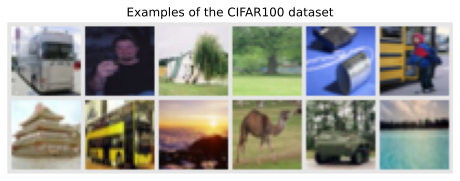

In [6]:
# Visualize some examples
NUM_IMAGES = 12
cifar_images = [cifar_train_set[np.random.randint(len(cifar_train_set))][0] for idx in range(NUM_IMAGES)]
cifar_images = torch.stack(cifar_images, dim=0)
img_grid = torchvision.utils.make_grid(cifar_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Examples of the CIFAR100 dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

## Data preprocessing

Next, we need to prepare the dataset in the training, validation and test split as mentioned before.
The torchvision package gives us the training and test set as two separate dataset objects.
The next code cells will merge the original training and test set, and then create the new train-val-test split.

In [7]:
# Merging original training and test set
cifar_all_images = np.concatenate([cifar_train_set.data, cifar_test_set.data], axis=0)
cifar_all_targets = torch.LongTensor(cifar_train_set.targets + cifar_test_set.targets)

To have an easier time handling the dataset, we define our own, simple dataset class below.
It takes a set of images, labels/targets, and image transformations, and
returns the corresponding images and labels element-wise.

In [8]:
class ImageDataset(data.Dataset):
    def __init__(self, imgs, targets, img_transform=None):
        """
        Inputs:
            imgs - Numpy array of shape [N,32,32,3] containing all images.
            targets - PyTorch array of shape [N] containing all labels.
            img_transform - A torchvision transformation that should be applied
                            to the images before returning. If none, no transformation
                            is applied.
        """
        super().__init__()
        self.img_transform = img_transform
        self.imgs = imgs
        self.targets = targets

    def __getitem__(self, idx):
        img, target = self.imgs[idx], self.targets[idx]
        img = Image.fromarray(img)

        if self.img_transform is not None:
            img = self.img_transform(img)

        return img, target

    def __len__(self):
        return self.imgs.shape[0]

Now, we can create the class splits.
We will assign the classes randomly to training, validation and test, and use a 80%-10%-10% split.

In [9]:
pl.seed_everything(0)  # Set seed for reproducibility
classes = torch.randperm(100)  # Returns random permutation of numbers 0 to 99
train_classes, val_classes, test_classes = classes[:80], classes[80:90], classes[90:]

INFO:pytorch_lightning.utilities.seed:Global seed set to 0


To get an intuition of the validation and test classes, we print the class names below:

In [10]:
# Printing validation and test classes
idx_to_class = {val: key for key, val in cifar_train_set.class_to_idx.items()}
print("Validation classes:", [idx_to_class[c.item()] for c in val_classes])
print("Test classes:", [idx_to_class[c.item()] for c in test_classes])

Validation classes: ['caterpillar', 'castle', 'skunk', 'ray', 'bus', 'motorcycle', 'keyboard', 'chimpanzee', 'possum', 'tiger']
Test classes: ['kangaroo', 'crocodile', 'butterfly', 'shark', 'forest', 'pickup_truck', 'telephone', 'lion', 'worm', 'mushroom']


As we can see, the classes have quite some variety and some classes might be easier to distinguish than others.

Finally, we can create the training, validation and test dataset according to our split above.
For this, we create dataset objects of our previously defined class `ImageDataset`.

In [11]:
def dataset_from_labels(imgs, targets, class_set, **kwargs):
    class_mask = (targets[:, None] == class_set[None, :]).any(dim=-1)
    return ImageDataset(imgs=imgs[class_mask], targets=targets[class_mask], **kwargs)

Here, we are normalizing the dataset and use small augmentations during training to prevent overfitting.

In [12]:
DATA_MEANS = (cifar_train_set.data / 255.0).mean(axis=(0, 1, 2))
DATA_STD = (cifar_train_set.data / 255.0).std(axis=(0, 1, 2))

test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(DATA_MEANS, DATA_STD)])
# For training, we add some augmentation.
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize(DATA_MEANS, DATA_STD),
    ]
)

train_set = dataset_from_labels(cifar_all_images, cifar_all_targets, train_classes, img_transform=train_transform)
val_set = dataset_from_labels(cifar_all_images, cifar_all_targets, val_classes, img_transform=test_transform)
test_set = dataset_from_labels(cifar_all_images, cifar_all_targets, test_classes, img_transform=test_transform)

## Data sampling

In [13]:
class FewShotBatchSampler:
    def __init__(self, dataset_targets, N_way, K_shot, include_query=False, shuffle=True, shuffle_once=False):
        """
        Inputs:
            dataset_targets - PyTorch tensor of the labels of the data elements.
            N_way - Number of classes to sample per batch.
            K_shot - Number of examples to sample per class in the batch.
            include_query - If True, returns batch of size N_way*K_shot*2, which
                            can be split into support and query set. Simplifies
                            the implementation of sampling the same classes but
                            distinct examples for support and query set.
            shuffle - If True, examples and classes are newly shuffled in each
                      iteration (for training)
            shuffle_once - If True, examples and classes are shuffled once in
                           the beginning, but kept constant across iterations
                           (for validation)
        """
        super().__init__()
        self.dataset_targets = dataset_targets
        self.N_way = N_way
        self.K_shot = K_shot
        self.shuffle = shuffle
        self.include_query = include_query
        if self.include_query:
            self.K_shot *= 2
        self.batch_size = self.N_way * self.K_shot  # Number of overall images per batch

        # Organize examples by class
        self.classes = torch.unique(self.dataset_targets).tolist()
        self.num_classes = len(self.classes)
        self.indices_per_class = {}
        self.batches_per_class = {}  # Number of K-shot batches that each class can provide
        for c in self.classes:
            self.indices_per_class[c] = torch.where(self.dataset_targets == c)[0]
            self.batches_per_class[c] = self.indices_per_class[c].shape[0] // self.K_shot

        # Create a list of classes from which we select the N classes per batch
        self.iterations = sum(self.batches_per_class.values()) // self.N_way
        self.class_list = [c for c in self.classes for _ in range(self.batches_per_class[c])]
        if shuffle_once or self.shuffle:
            self.shuffle_data()
        else:
            # For testing, we iterate over classes instead of shuffling them
            sort_idxs = [
                i + p * self.num_classes for i, c in enumerate(self.classes) for p in range(self.batches_per_class[c])
            ]
            self.class_list = np.array(self.class_list)[np.argsort(sort_idxs)].tolist()

    def shuffle_data(self):
        # Shuffle the examples per class
        for c in self.classes:
            perm = torch.randperm(self.indices_per_class[c].shape[0])
            self.indices_per_class[c] = self.indices_per_class[c][perm]
        # Shuffle the class list from which we sample. Note that this way of shuffling
        # does not prevent to choose the same class twice in a batch. However, for
        # training and validation, this is not a problem.
        random.shuffle(self.class_list)

    def __iter__(self):
        # Shuffle data
        if self.shuffle:
            self.shuffle_data()

        # Sample few-shot batches
        start_index = defaultdict(int)
        for it in range(self.iterations):
            class_batch = self.class_list[it * self.N_way : (it + 1) * self.N_way]  # Select N classes for the batch
            index_batch = []
            for c in class_batch:  # For each class, select the next K examples and add them to the batch
                index_batch.extend(self.indices_per_class[c][start_index[c] : start_index[c] + self.K_shot])
                start_index[c] += self.K_shot
            if self.include_query:  # If we return support+query set, sort them so that they are easy to split
                index_batch = index_batch[::2] + index_batch[1::2]
            yield index_batch

    def __len__(self):
        return self.iterations

Now, we can create our intended data loaders by passing an object of `FewShotBatchSampler` as `batch_sampler=...` input to the PyTorch data loader object.
we will use a 5-class 4-shot training setting.
This means that each support set contains 5 classes with 4 examples each, i.e., 20 images overall.

In [14]:
N_WAY = 5
K_SHOT = 4
train_data_loader = data.DataLoader(
    train_set,
    batch_sampler=FewShotBatchSampler(train_set.targets, include_query=True, N_way=N_WAY, K_shot=K_SHOT, shuffle=True),
    num_workers=4,
)
val_data_loader = data.DataLoader(
    val_set,
    batch_sampler=FewShotBatchSampler(
        val_set.targets, include_query=True, N_way=N_WAY, K_shot=K_SHOT, shuffle=False, shuffle_once=True
    ),
    num_workers=4,
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


For simplicity, we implemented the sampling of a support and query set as sampling a support set with twice the number of examples.
After sampling a batch from the data loader, we need to split it into a support and query set.
We can summarize this step in the following function:

In [15]:
def split_batch(imgs, targets):
    support_imgs, query_imgs = imgs.chunk(2, dim=0)
    support_targets, query_targets = targets.chunk(2, dim=0)
    return support_imgs, query_imgs, support_targets, query_targets

Finally, to ensure that our implementation of the data sampling process is correct, we can sample a batch and visualize its support and query set.
What we would like to see is that the support and query set have the same classes, but distinct examples.

In [16]:
imgs, targets = next(iter(val_data_loader))  # We use the validation set since it does not apply augmentations
support_imgs, query_imgs, _, _ = split_batch(imgs, targets)
support_grid = torchvision.utils.make_grid(support_imgs, nrow=K_SHOT, normalize=True, pad_value=0.9)
support_grid = support_grid.permute(1, 2, 0)
query_grid = torchvision.utils.make_grid(query_imgs, nrow=K_SHOT, normalize=True, pad_value=0.9)
query_grid = query_grid.permute(1, 2, 0)

fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].imshow(support_grid)
ax[0].set_title("Support set")
ax[0].axis("off")
ax[1].imshow(query_grid)
ax[1].set_title("Query set")
ax[1].axis("off")
fig.suptitle("Few Shot Batch", weight="bold")
fig.show()
plt.close(fig)

As we can see, the support and query set have the same five classes, but different examples.
The models will be tasked to classify the examples in the query set by learning from the support set and its labels.

## ProtoNet implementation

Now that we know how a ProtoNet works in principle, let's look at how we can apply to our specific problem of few-shot image classification, and implement it below.
First, we need to define the encoder function $f_{\theta}$.

Here, we go with a DenseNet since it is in general more parameter efficient than ResNet.
Luckily, we do not need to implement DenseNet ourselves again and can rely on torchvision's model package instead.
We use common hyperparameters of 64 initial feature channels, add 32 per block, and use a bottleneck size of 64 (i.e. 2 times the growth rate).
We use 4 stages of 6 layers each, which results in overall about 1 million parameters.
Note that the torchvision package assumes that the last layer is used for classification and hence calls its output size `num_classes`.
However, we can instead just use it as the feature space of ProtoNet, and choose an arbitrary dimensionality.
We will use the same network for other algorithms in this notebook to ensure a fair comparison.

In [17]:
def get_convnet(output_size):
    convnet = torchvision.models.DenseNet(
        growth_rate=32,
        block_config=(6, 6, 6, 6),
        bn_size=2,
        num_init_features=64,
        num_classes=output_size,  # Output dimensionality
    )
    return convnet

Next, we can look at implementing ProtoNet.
We will define it as PyTorch Lightning module to use all functionalities of PyTorch Lightning.
The first step during training is to encode all images in a batch with our network.
Next, we calculate the class prototypes from the support set (function `calculate_prototypes`), and classify the query set examples according to the prototypes (function `classify_feats`).
Keep in mind that we use the data sampling described before, such that the support and query set are stacked together in the batch.
Thus, we use our previously defined function `split_batch` to split them apart.
The full code can be found below.

In [18]:
class ProtoNet(pl.LightningModule):
    def __init__(self, proto_dim, lr):
        """Inputs.

        proto_dim - Dimensionality of prototype feature space
        lr - Learning rate of Adam optimizer
        """
        super().__init__()
        self.save_hyperparameters()
        self.model = get_convnet(output_size=self.hparams.proto_dim)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[140, 180], gamma=0.1)
        return [optimizer], [scheduler]

    @staticmethod
    def calculate_prototypes(features, targets):
        # Given a stack of features vectors and labels, return class prototypes
        # features - shape [N, proto_dim], targets - shape [N]
        classes, _ = torch.unique(targets).sort()  # Determine which classes we have
        prototypes = []
        for c in classes:
            p = features[torch.where(targets == c)[0]].mean(dim=0)  # Average class feature vectors
            prototypes.append(p)
        prototypes = torch.stack(prototypes, dim=0)
        # Return the 'classes' tensor to know which prototype belongs to which class
        return prototypes, classes

    def classify_feats(self, prototypes, classes, feats, targets):
        # Classify new examples with prototypes and return classification error
        dist = torch.pow(prototypes[None, :] - feats[:, None], 2).sum(dim=2)  # Squared euclidean distance
        preds = F.log_softmax(-dist, dim=1)
        labels = (classes[None, :] == targets[:, None]).long().argmax(dim=-1)
        acc = (preds.argmax(dim=1) == labels).float().mean()
        return preds, labels, acc

    def calculate_loss(self, batch, mode):
        # Determine training loss for a given support and query set
        imgs, targets = batch
        features = self.model(imgs)  # Encode all images of support and query set
        support_feats, query_feats, support_targets, query_targets = split_batch(features, targets)
        prototypes, classes = ProtoNet.calculate_prototypes(support_feats, support_targets)
        preds, labels, acc = self.classify_feats(prototypes, classes, query_feats, query_targets)
        loss = F.cross_entropy(preds, labels)

        self.log("%s_loss" % mode, loss)
        self.log("%s_acc" % mode, acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self.calculate_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        self.calculate_loss(batch, mode="val")

For validation, we use the same principle as training and sample support and query sets from the hold-out 10 classes.
However, this gives us noisy scores depending on which query sets are chosen to which support sets.
This is why we will use a different strategy during testing.
For validation, our training strategy is sufficient since it is much
faster than testing, and gives a good estimate of the training
generalization as long as we keep the support-query sets constant across
validation iterations.

## Training

After implementing the model, we can already start training it.
We use our common PyTorch Lightning training function, and train the model for 200 epochs.
The training function takes `model_class` as input argument, i.e. the
PyTorch Lightning module class that should be trained, since we will
reuse this function for other algorithms as well.

In [19]:
def train_model(model_class, train_loader, val_loader, **kwargs):
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, model_class.__name__),
        gpus=1 if str(device) == "cuda:0" else 0,
        max_epochs=200,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
            LearningRateMonitor("epoch"),
        ],
        progress_bar_refresh_rate=0,
    )
    trainer.logger._default_hp_metric = None

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, model_class.__name__ + ".ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model at %s, loading..." % pretrained_filename)
        # Automatically loads the model with the saved hyperparameters
        model = model_class.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)  # To be reproducable
        model = model_class(**kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = model_class.load_from_checkpoint(
            trainer.checkpoint_callback.best_model_path
        )  # Load best checkpoint after training

    return model

Below is the training call for our ProtoNet.
We use a 64-dimensional feature space.
Larger feature spaces showed to give noisier results since the squared euclidean distance becomes proportionally larger in expectation, and smaller feature spaces might not allow for enough flexibility.
We recommend to load the pre-trained model here at first, but feel free
to play around with the hyperparameters yourself.

In [20]:
protonet_model = train_model(
    ProtoNet, proto_dim=64, lr=2e-4, train_loader=train_data_loader, val_loader=val_data_loader
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Found pretrained model at saved_models/MetaLearning/ProtoNet.ckpt, loading...


## Testing

Our goal of meta-learning is to obtain a model that can quickly adapt to a new task, or in this case, new classes to distinguish between.
To test this, we will use our trained ProtoNet and adapt it to the 10 test classes.
Thereby, we pick $k$ examples per class from which we determine the prototypes, and test the classification accuracy on all other examples.
This can be seen as using the $k$ examples per class as support set, and the rest of the dataset as a query set.
We iterate through the dataset such that each example has been once included in a support set.
The average performance over all support sets tells us how well we can expect ProtoNet to perform when seeing only $k$ examples per class.
During training, we used $k=4$.
In testing, we will experiment with $k=\{2,4,8,16,32\}$ to get a better sense of how $k$ influences the results.
We would expect that we achieve higher accuracies the more examples we have in the support set, but we don't know how it scales.
Hence, let's first implement a function that executes the testing procedure for a given $k$:

In [21]:
@torch.no_grad()
def test_proto_net(model, dataset, data_feats=None, k_shot=4):
    """Inputs.

    model - Pretrained ProtoNet model
    dataset - The dataset on which the test should be performed.
              Should be instance of ImageDataset
    data_feats - The encoded features of all images in the dataset.
                 If None, they will be newly calculated, and returned
                 for later usage.
    k_shot - Number of examples per class in the support set.
    """
    model = model.to(device)
    model.eval()
    num_classes = dataset.targets.unique().shape[0]
    exmps_per_class = dataset.targets.shape[0] // num_classes  # We assume uniform example distribution here

    # The encoder network remains unchanged across k-shot settings. Hence, we only need
    # to extract the features for all images once.
    if data_feats is None:
        # Dataset preparation
        dataloader = data.DataLoader(dataset, batch_size=128, num_workers=4, shuffle=False, drop_last=False)

        img_features = []
        img_targets = []
        for imgs, targets in tqdm(dataloader, "Extracting image features", leave=False):
            imgs = imgs.to(device)
            feats = model.model(imgs)
            img_features.append(feats.detach().cpu())
            img_targets.append(targets)
        img_features = torch.cat(img_features, dim=0)
        img_targets = torch.cat(img_targets, dim=0)
        # Sort by classes, so that we obtain tensors of shape [num_classes, exmps_per_class, ...]
        # Makes it easier to process later
        img_targets, sort_idx = img_targets.sort()
        img_targets = img_targets.reshape(num_classes, exmps_per_class).transpose(0, 1)
        img_features = img_features[sort_idx].reshape(num_classes, exmps_per_class, -1).transpose(0, 1)
    else:
        img_features, img_targets = data_feats

    # We iterate through the full dataset in two manners. First, to select the k-shot batch.
    # Second, the evaluate the model on all other examples
    accuracies = []
    for k_idx in tqdm(range(0, img_features.shape[0], k_shot), "Evaluating prototype classification", leave=False):
        # Select support set and calculate prototypes
        k_img_feats = img_features[k_idx : k_idx + k_shot].flatten(0, 1)
        k_targets = img_targets[k_idx : k_idx + k_shot].flatten(0, 1)
        prototypes, proto_classes = model.calculate_prototypes(k_img_feats, k_targets)
        # Evaluate accuracy on the rest of the dataset
        batch_acc = 0
        for e_idx in range(0, img_features.shape[0], k_shot):
            if k_idx == e_idx:  # Do not evaluate on the support set examples
                continue
            e_img_feats = img_features[e_idx : e_idx + k_shot].flatten(0, 1)
            e_targets = img_targets[e_idx : e_idx + k_shot].flatten(0, 1)
            _, _, acc = model.classify_feats(prototypes, proto_classes, e_img_feats, e_targets)
            batch_acc += acc.item()
        batch_acc /= img_features.shape[0] // k_shot - 1
        accuracies.append(batch_acc)

    return (mean(accuracies), stdev(accuracies)), (img_features, img_targets)

Testing ProtoNet is relatively quick if we have processed all images once. Hence, we can do in this notebook:

In [22]:
protonet_accuracies = dict()
data_feats = None
for k in [2, 4, 8, 16, 32]:
    protonet_accuracies[k], data_feats = test_proto_net(protonet_model, test_set, data_feats=data_feats, k_shot=k)
    print(
        "Accuracy for k=%i: %4.2f%% (+-%4.2f%%)"
        % (k, 100.0 * protonet_accuracies[k][0], 100 * protonet_accuracies[k][1])
    )

Extracting image features:   0%|          | 0/47 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Evaluating prototype classification:   0%|          | 0/300 [00:00<?, ?it/s]

Accuracy for k=2: 44.30% (+-3.63%)


Evaluating prototype classification:   0%|          | 0/150 [00:00<?, ?it/s]

Accuracy for k=4: 52.07% (+-2.27%)


Evaluating prototype classification:   0%|          | 0/75 [00:00<?, ?it/s]

Accuracy for k=8: 57.59% (+-1.30%)


Evaluating prototype classification:   0%|          | 0/38 [00:00<?, ?it/s]

Accuracy for k=16: 62.56% (+-1.02%)


Evaluating prototype classification:   0%|          | 0/19 [00:00<?, ?it/s]

Accuracy for k=32: 66.49% (+-0.87%)


Before discussing the results above, let's first plot the accuracies over number of examples in the support set:

In [23]:
def plot_few_shot(acc_dict, name, color=None, ax=None):
    sns.set()
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    ks = sorted(list(acc_dict.keys()))
    mean_accs = [acc_dict[k][0] for k in ks]
    std_accs = [acc_dict[k][1] for k in ks]
    ax.plot(ks, mean_accs, marker="o", markeredgecolor="k", markersize=6, label=name, color=color)
    ax.fill_between(
        ks,
        [m - s for m, s in zip(mean_accs, std_accs)],
        [m + s for m, s in zip(mean_accs, std_accs)],
        alpha=0.2,
        color=color,
    )
    ax.set_xticks(ks)
    ax.set_xlim([ks[0] - 1, ks[-1] + 1])
    ax.set_xlabel("Number of shots per class", weight="bold")
    ax.set_ylabel("Accuracy", weight="bold")
    if len(ax.get_title()) == 0:
        ax.set_title("Few-Shot Performance " + name, weight="bold")
    else:
        ax.set_title(ax.get_title() + " and " + name, weight="bold")
    ax.legend()
    return ax

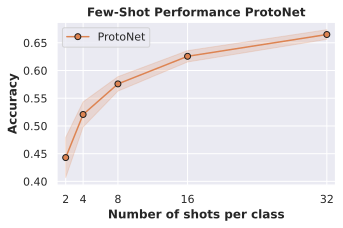

In [24]:
ax = plot_few_shot(protonet_accuracies, name="ProtoNet", color="C1")
plt.show()
plt.close()

As we initially expected, the performance of ProtoNet indeed increases the more samples we have.
However, even with just two samples per class, we classify almost half of the images correctly, which is well above random accuracy (10%).
The curve shows an exponentially dampend trend, meaning that adding 2 extra examples to $k=2$ has a much higher impact than adding 2 extra samples if we already have $k=16$.
Nonetheless, we can say that ProtoNet adapts fairly well to new classes.

## Reference


*   https://colab.research.google.com/github/PytorchLightning/lightning-tutorials/blob/publication/.notebooks/course_UvA-DL/12-meta-learning.ipynb


